**Market Risk Indicator**

[*********************100%%**********************]  4 of 4 completed


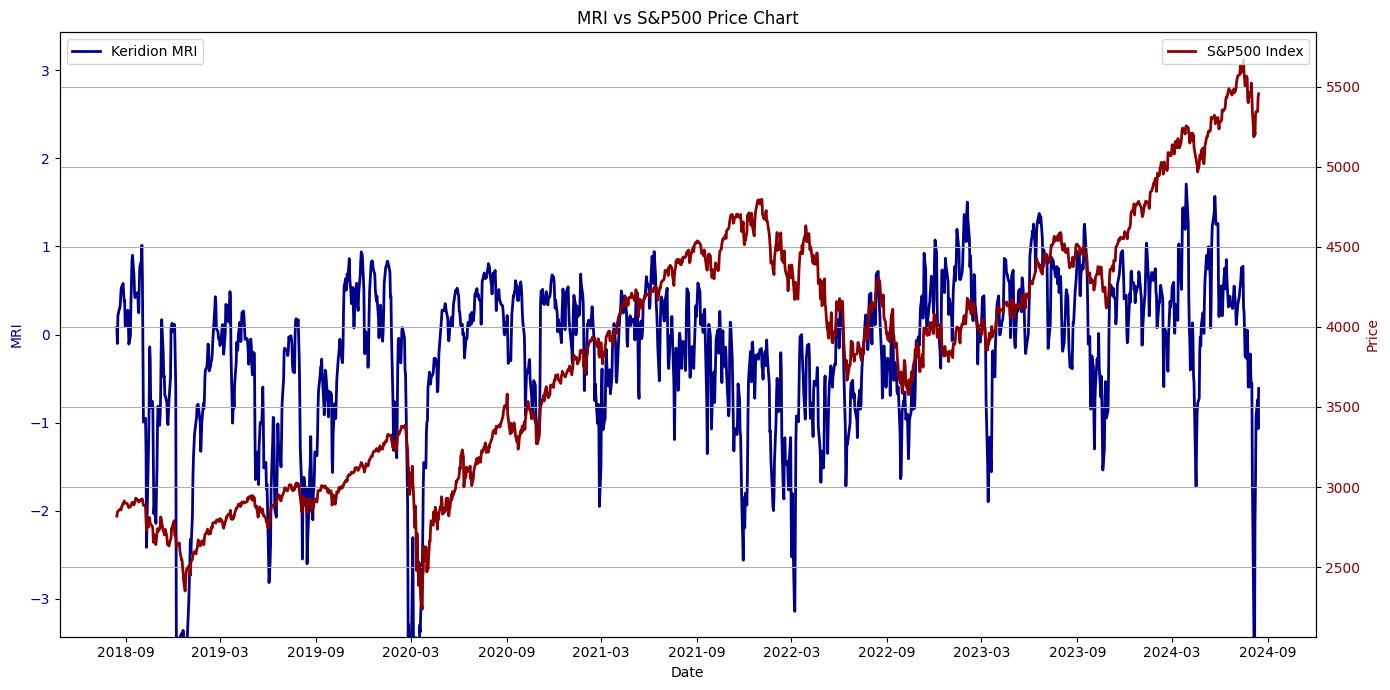

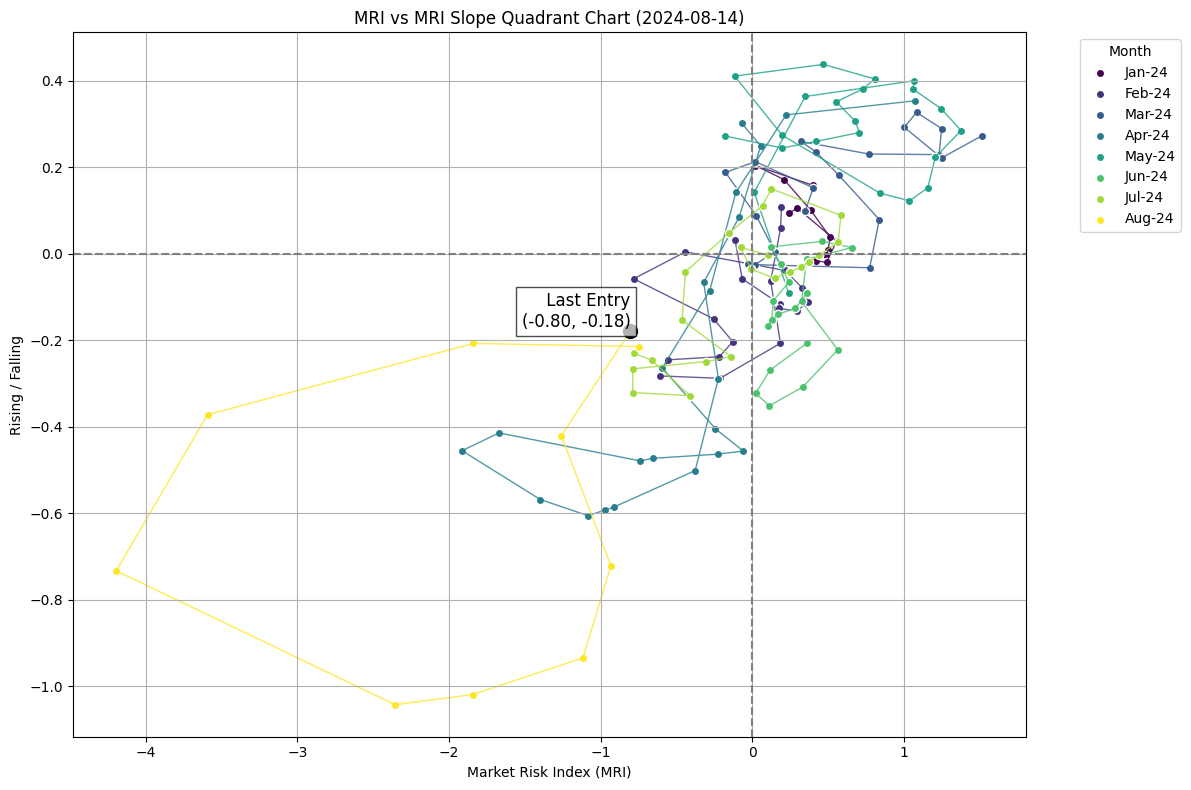

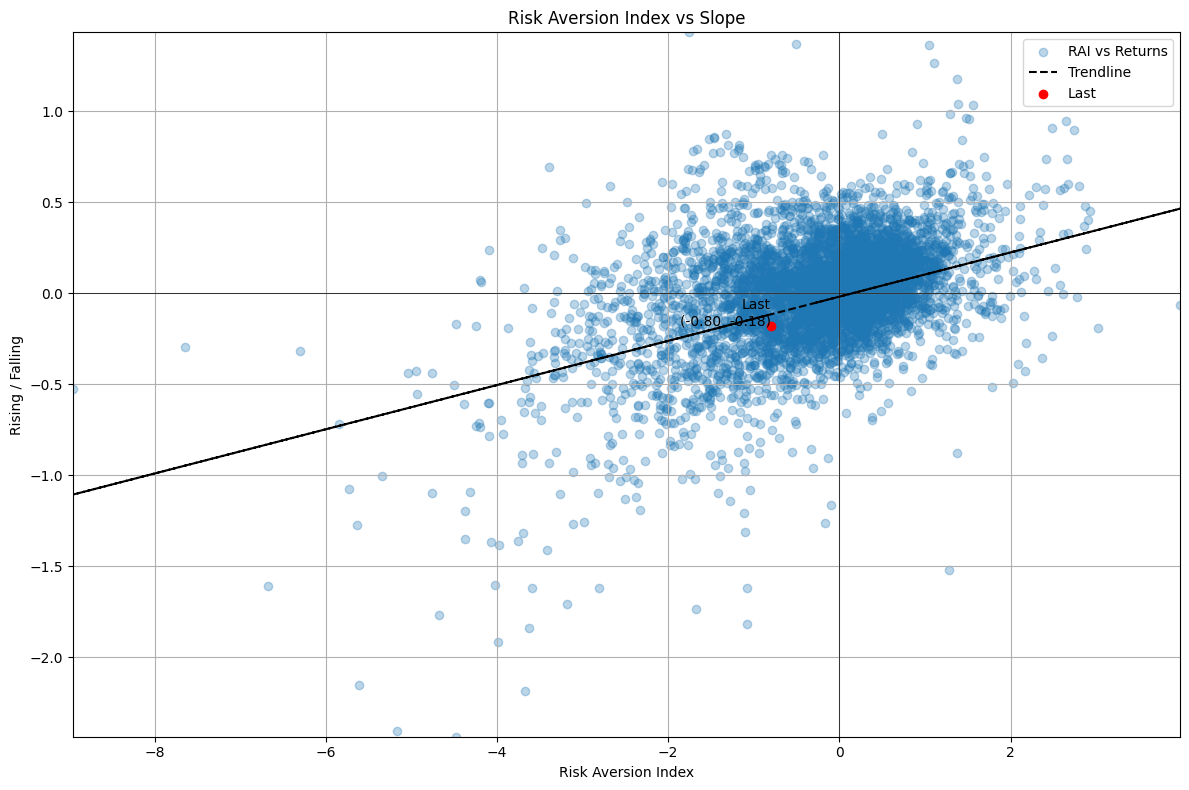

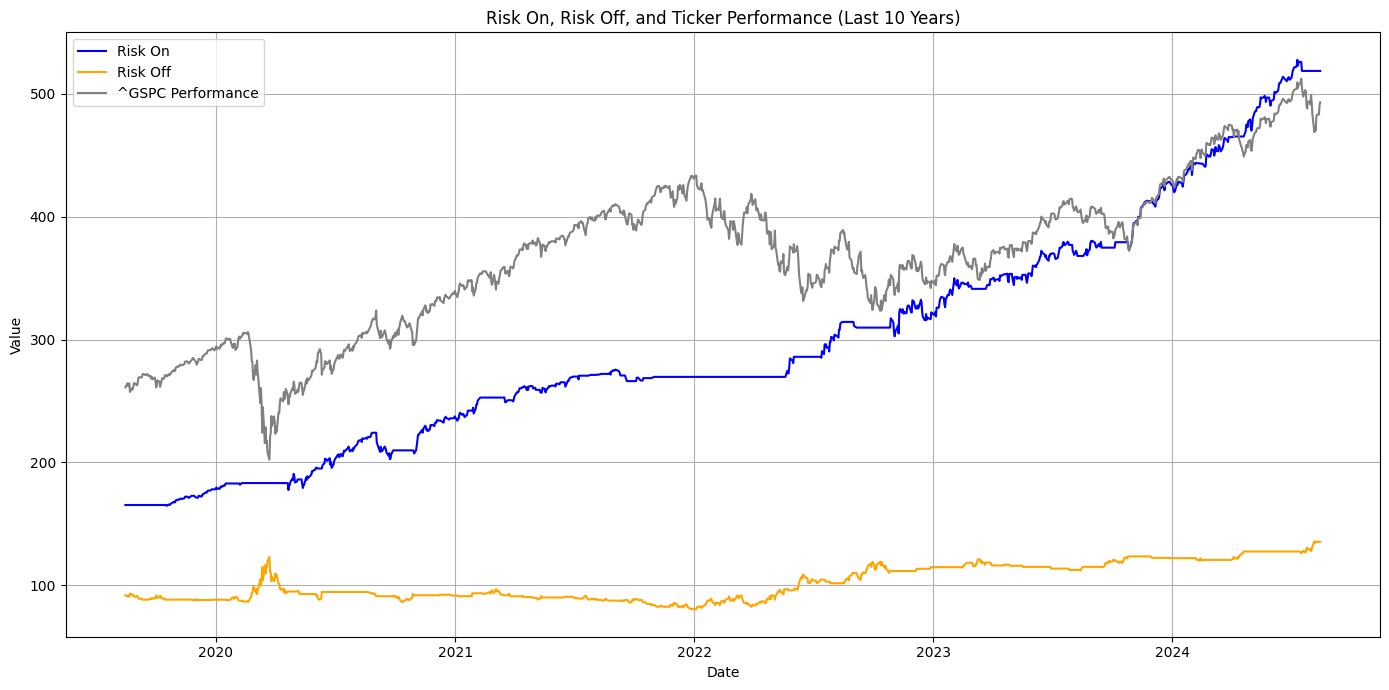

In [2]:
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression

def get_data(tickers, start_date, end_date):
    try:
        data = yf.download(tickers, start=start_date, end=end_date)
        data = data['Close'].ffill().bfill()  # Forward-fill NaNs, then backward-fill if needed
        return data
    except Exception as e:
        print(f"Error retrieving data: {e}")
        return pd.DataFrame()

def calculate_mri(data, lookback_periods, slope_factor):
    daily_returns = (data - data.shift(1)) / data.shift(1)
    comparison_index = daily_returns[['^VIX', '^MOVE', 'EVZ']]
    mri_list = []

    for lookback in lookback_periods:
        offset_values = {}
        for ticker in comparison_index.columns:
            offset_values[ticker] = -comparison_index[ticker].rolling(window=lookback).sum()
        offset_values_df = pd.DataFrame(offset_values).dropna()

        nm_value = pd.DataFrame(index=offset_values_df.index)
        for ticker in offset_values_df.columns:
            rolling_min = offset_values_df[ticker].rolling(window=lookback).min()
            rolling_max = offset_values_df[ticker].rolling(window=lookback).max()
            nm_value[ticker] = np.where(
                (rolling_max - rolling_min) != 0,
                (offset_values_df[ticker] - rolling_min) / (rolling_max - rolling_min),
                0
            )

        absolute_values = np.abs(2 * nm_value - 1)
        z_scores = pd.DataFrame(index=offset_values_df.index)

        for ticker in comparison_index.columns:
            rolling_mean = data[ticker].rolling(window=lookback).mean()
            rolling_std = data[ticker].rolling(window=lookback).std()
            valid_index = rolling_mean.index.intersection(offset_values_df.index)
            z_scores = z_scores.reindex(valid_index)

            z_scores[ticker] = np.where(
                rolling_std.loc[valid_index] > 0,
                (data[ticker].loc[valid_index] - rolling_mean.loc[valid_index]) / rolling_std.loc[valid_index],
                0
            )

        combo_rhs = -1 * (z_scores * absolute_values).sum(axis=1) / absolute_values.sum(axis=1)
        mri_list.append(combo_rhs)

    mri_avg = pd.concat(mri_list, axis=1).mean(axis=1) * slope_factor
    mri = (0.33 * mri_avg + 0.67 * mri_avg.shift(1)) / 10
    mri.fillna(0, inplace=True)
    return mri

def calculate_mri_slope(mri, lookback_period):
    slopes = pd.Series(index=mri.index, dtype=float)
    for i in range(lookback_period, len(mri)):
        x = np.arange(lookback_period).reshape(-1, 1)
        y = mri.iloc[i-lookback_period:i].values
        
        model = LinearRegression()
        model.fit(x, y)
        slopes.iloc[i] = model.coef_[0]
    slopes.fillna(0, inplace=True)
    return slopes

def calculate_risk_aversion_index(data, lookback_periods):
    daily_returns = (data - data.shift(1)) / data.shift(1)
    comparison_index = daily_returns[['^VIX', '^MOVE', 'EVZ']]
    
    normalisation_indices = []
    
    for lookback in lookback_periods:
        offset_values = {}
        for ticker in comparison_index.columns:
            offset_values[ticker] = -comparison_index[ticker].rolling(window=lookback).sum()
        offset_values_df = pd.DataFrame(offset_values).dropna()

        norm_df = pd.DataFrame(index=offset_values_df.index)
        for ticker in offset_values_df.columns:
            rolling_min = offset_values_df[ticker].rolling(window=lookback).min()
            rolling_max = offset_values_df[ticker].rolling(window=lookback).max()
            norm_df[ticker] = np.where(
                (rolling_max - rolling_min) != 0,
                (offset_values_df[ticker] - rolling_min) / (rolling_max - rolling_min),
                0
            )
        
        combo_values = norm_df.mean(axis=1)
        normalisation_indices.append(combo_values)
    
    combined_normalisation_indices = pd.concat(normalisation_indices, axis=1).mean(axis=1)
    risk_aversion_index = 2 * combined_normalisation_indices
    return risk_aversion_index

def calculate_risk(data, ticker_returns, sign):
    # Initialize only the first value of risk_on and risk_off to 100
    risk_on = pd.Series(index=data.index, dtype=float)
    risk_off = pd.Series(index=data.index, dtype=float)
    risk_on.iloc[0] = 100.0
    risk_off.iloc[0] = 100.0

    # Calculate the risk-on and risk-off values based on the sign and returns
    for i in range(1, len(data)):
        if i >= len(ticker_returns) or i >= len(sign):
            continue

        if sign.iloc[i-1] > 0:
            # Risk-on strategy: increase based on positive returns
            risk_on.iloc[i] = risk_on.iloc[i-1] * (1 + ticker_returns.iloc[i])
            risk_off.iloc[i] = risk_off.iloc[i-1]
        else:
            # Risk-off strategy: decrease based on negative returns
            risk_off.iloc[i] = risk_off.iloc[i-1] * (1 - ticker_returns.iloc[i])
            risk_on.iloc[i] = risk_on.iloc[i-1]
    risk_on = risk_on.ffill().bfill() / 11
    risk_off = risk_off.ffill().bfill() / 5
    return risk_on, risk_off

def calculate_ticker_performance(data, ticker_returns):
    ticker_performance = pd.Series(100, index=data.index, dtype=float)  # Start with 100
    
    for i in range(1, len(ticker_performance)):
        if i >= len(ticker_returns):
            continue  # Ensure we don't go out of bounds
        current_return = ticker_returns.iloc[i]
        ticker_performance.iloc[i] = ticker_performance.iloc[i-1] * (1 + current_return)
    return ticker_performance

def plot_data(data, mri, gspc_ticker='^GSPC', start_date=None, end_date=None):
    if start_date and end_date:
        data = data.loc[start_date:end_date]
        mri = mri.loc[start_date:end_date]
    
    # Convert end_date to datetime if it's a string
    end_date = pd.to_datetime(end_date)
    start_date_6_years_ago = end_date - pd.DateOffset(years=6)

    # Filter data for the last 6 years
    data = data.loc[start_date_6_years_ago:end_date]
    mri = mri.loc[start_date_6_years_ago:end_date]
    
    plt.figure(figsize=(14, 7))
    
    ax1 = plt.gca()
    ax1.plot(mri.index, mri, label='Keridion MRI', color='darkblue', linewidth=2)  # Darker blue and thicker line
    ax1.set_xlabel('Date')
    ax1.set_ylabel('MRI', color='darkblue')
    ax1.tick_params(axis='y', labelcolor='darkblue')
    
    ax2 = ax1.twinx()
    ax2.plot(data.index, data[gspc_ticker], label='S&P500 Index', color='darkred', linewidth=2)  # Darker red and thicker line
    ax2.set_ylabel('Price', color='darkred')
    ax2.tick_params(axis='y', labelcolor='darkred')
    
    # Determine the scaling factor for MRI
    price_range = data[gspc_ticker].max() - data[gspc_ticker].min()
    mri_range = 0.5  # We want 0.5 MRI to map to 500 units of price
    scaling_factor = 500 / mri_range
    
    # Adjust MRI axis to match scaling factor
    mri_min, mri_max = mri.min(), mri.max()
    mri_range_actual = mri_max - mri_min
    margin = mri_range_actual * 0.1  # Adding margin for better visualization
    ax1.set_ylim(mri_min - margin, mri_max + margin)
    
    # Adjust y-axis limits based on price and scaling factor
    ax1.set_ylim(-price_range / scaling_factor, price_range / scaling_factor)
    
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    
    plt.title(f"MRI vs S&P500 Price Chart")
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

dimport plotly.graph_objects as go
import pandas as pd
import numpy as np

# Function to plot quadrant chart using Plotly
def plot_quadrant_chart_plotly(mri_dif, mri_slope, ticker):
    # Create DataFrame for plotting
    df = pd.DataFrame({'MRI': mri_dif + 0.44, 'MRI Slope': mri_slope * 4}, index=pd.to_datetime(mri_dif.index))
    
    # Filter data for the last 12 months
    end_date = df.index.max()
    start_date = end_date - pd.DateOffset(months=7)
    df = df.loc[start_date:end_date]
    
    # Create period-based color mapping
    df['Month'] = df.index.to_period('M')
    months = df['Month'].unique()
    colors = np.linspace(0, 1, len(months))  # Generate a sequence of numbers to use for color mapping
    month_labels = [month.start_time.strftime('%b-%y') for month in months]
    
    # Initialize Plotly figure
    fig = go.Figure()
    
    # Plot each month's data with different colors
    for i, (month, label) in enumerate(zip(months, month_labels)):
        month_data = df[df['Month'] == month]
        fig.add_trace(go.Scatter(
            x=month_data['MRI'], 
            y=month_data['MRI Slope'], 
            mode='markers+lines', 
            marker=dict(color=colors[i], size=10, line=dict(width=2, color='white')), 
            line=dict(color=colors[i], width=3),
            name=label
        ))
    
    # Mark the last entry
    last_entry = df.iloc[-1]
    fig.add_trace(go.Scatter(
        x=[last_entry['MRI']], 
        y=[last_entry['MRI Slope']], 
        mode='markers+text', 
        marker=dict(color='black', size=12, line=dict(width=2, color='black')),
        text=[f' Last Entry\n({last_entry["MRI"]:.2f}, {last_entry["MRI Slope"]:.2f})'],
        textposition='top right',
        name='Last Entry'
    ))
    
    # Add vertical and horizontal lines for the axes
    fig.add_shape(type='line', x0=0, y0=df['MRI Slope'].min(), x1=0, y1=df['MRI Slope'].max(),
                  line=dict(color='gray', dash='dash'))
    fig.add_shape(type='line', x0=df['MRI'].min(), y0=0, x1=df['MRI'].max(), y1=0,
                  line=dict(color='gray', dash='dash'))
    
    # Update layout with labels, titles, and grid
    fig.update_layout(
        title=f'MRI vs MRI Slope Quadrant Chart ({end_date.strftime("%Y-%m-%d")})',
        xaxis_title='Market Risk Index (MRI)',
        yaxis_title='Rising / Falling',
        legend_title='Month',
        legend=dict(orientation='v', yanchor='top', y=1.02, xanchor='left', x=1.05),
        margin=dict(l=50, r=50, t=50, b=50),
        template='plotly_white',
        showlegend=True,
    )
    
    # Add grid
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')

    # Show the plot
    fig.show()


def plot_risk_aversion_vs_returns(risk_aversion, returns, ticker):
    valid_mask = ~risk_aversion.isna() & ~returns.isna()
    risk_aversion = risk_aversion[valid_mask] - 0.19
    returns = returns[valid_mask] * 4

    if risk_aversion.empty or returns.empty:
        print("No valid data to plot.")
        return
    
    plt.figure(figsize=(12, 8))
    plt.scatter(risk_aversion, returns, alpha=0.3, label='RAI vs Returns')

    if len(risk_aversion) > 0 and len(returns) > 0:
        model = LinearRegression()
        model.fit(risk_aversion.values.reshape(-1, 1), returns.values.reshape(-1, 1))
        trendline = model.predict(risk_aversion.values.reshape(-1, 1)) - 0.05
        plt.plot(risk_aversion, trendline, color='black', linestyle='--', label='Trendline')

        last_point = len(risk_aversion) - 1
        plt.scatter(risk_aversion.iloc[last_point], returns.iloc[last_point], color='red', label='Last')
        plt.text(risk_aversion.iloc[last_point], returns.iloc[last_point],
                 f'Last\n({risk_aversion.iloc[last_point]:.2f}, {returns.iloc[last_point]:.2f})', 
                 horizontalalignment='right')

    # Set limits to center the origin (0,0)
    xlim = (min(risk_aversion.min(), 0), max(risk_aversion.max(), 0))
    ylim = (min(returns.min(), 0), max(returns.max(), 0))
    
    plt.xlim(xlim)
    plt.ylim(ylim)

    plt.title(f'Risk Aversion Index vs Slope')
    plt.xlabel('Risk Aversion Index')
    plt.ylabel('Rising / Falling')
    plt.grid(True)
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_risk_on_risk_off_performance(risk_on, risk_off, ticker_performance, selected_ticker):
    # Get the current date
    current_date = pd.Timestamp.today()
    
    # Calculate the date 10 years ago from the current date
    ten_years_ago = current_date - pd.DateOffset(years=5)
    
    # Filter the data for the last 10 years
    risk_on_filtered = risk_on[risk_on.index >= ten_years_ago]
    risk_off_filtered = risk_off[risk_off.index >= ten_years_ago]
    ticker_performance_filtered = ticker_performance[ticker_performance.index >= ten_years_ago]
    
    # Plotting
    plt.figure(figsize=(14, 7))
    plt.plot(risk_on_filtered.index, risk_on_filtered, label='Risk On', color='blue')
    plt.plot(risk_off_filtered.index, risk_off_filtered, label='Risk Off', color='orange')
    plt.plot(ticker_performance_filtered.index, ticker_performance_filtered, label=f'{selected_ticker} Performance', color='grey')
    
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Risk On, Risk Off, and Ticker Performance (Last 10 Years)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Main Execution
tickers = ['^VIX', '^MOVE', 'EVZ', '^GSPC']
start_date = "2001-09-06"

selected_ticker = '^GSPC'

end_date_input = input("Enter the end date (YYYY-MM-DD) or press Enter to use the current date: ")
if end_date_input:
    end_date = end_date_input
else:
    end_date = datetime.datetime.now().strftime('%Y-%m-%d')

data = get_data(tickers, start_date, end_date)
if data.empty:
    print("No data available.")
else:
    # User input for fast and slow MRI weights
    try:
        fast_weight = input("Enter the weight for fast MRI (as a percentage, press Enter for default 50%): ").strip()
        fast_weight = float(fast_weight) / 100 if fast_weight else 0.5

        slow_weight = input("Enter the weight for slow MRI (as a percentage, press Enter for default 50%): ").strip()
        slow_weight = float(slow_weight) / 100 if slow_weight else 0.5

        # Ensure weights sum to 1
        if fast_weight + slow_weight != 1:
            print("The weights for fast and slow MRI must sum to 1. Setting to default (50% each).")
            fast_weight = slow_weight = 0.5  # Default to equal weights if input is incorrect
    except ValueError:
        print("Invalid input. Setting weights to default (50% each).")
        fast_weight = slow_weight = 0.5

    lookback_periods_fast = [5, 10, 22, 66, 90]
    lookback_periods_slow = [66, 126, 190, 252, 520]
    slope_factor_fast = 10
    slope_factor_slow = 22

    data_mri_fast = calculate_mri(data, lookback_periods_fast, slope_factor_fast)
    data_mri_slow = calculate_mri(data, lookback_periods_slow, slope_factor_slow)

    # Weighted average of fast and slow MRI
    data_mri_combined = (fast_weight * data_mri_fast + slow_weight * data_mri_slow)
    sign = np.sign(data_mri_combined)

    data_mri_combined = data_mri_combined.ffill().bfill()

    data_slope_fast = calculate_mri_slope(data_mri_combined, slope_factor_fast)
    data_slope_slow = calculate_mri_slope(data_mri_combined, slope_factor_slow)
    data_slope_combined = (fast_weight * data_slope_fast + slow_weight * data_slope_slow)

    data_rai_fast = calculate_risk_aversion_index(data, lookback_periods_fast)
    data_rai_slow = calculate_risk_aversion_index(data, lookback_periods_slow)
    data_rai_combined = (data_rai_fast + data_rai_slow) / 2

    daily_returns = data['^GSPC'].pct_change()
    mri_dif = data_mri_combined.diff()

    # Calculate new series
    risk_on, risk_off = calculate_risk(data, daily_returns, sign)
    ticker_performance = calculate_ticker_performance(data, daily_returns)

    # Plot results
    plot_data(data, data_mri_combined, gspc_ticker='^GSPC', start_date=start_date, end_date=end_date)
    plot_quadrant_chart(data_mri_combined, data_slope_combined, selected_ticker)
    plot_risk_aversion_vs_returns(data_mri_combined, data_slope_combined, selected_ticker)
    plot_risk_on_risk_off_performance(risk_on, risk_off, ticker_performance, selected_ticker)

In [4]:
from newsapi import NewsApiClient

def fetch_news_articles(api_key, query, sources=None, language='en', page_size=3):
    newsapi = NewsApiClient(api_key=api_key)
    try:
        all_articles = newsapi.get_everything(q=query,
                                              sources=sources,
                                              language=language,
                                              sort_by='publishedAt',  # Sort by publication date
                                              page_size=page_size)
        articles = all_articles['articles']
        return articles
    except Exception as e:
        print(f"Error fetching news articles: {e}")
        return []

def display_news_articles(articles):
    valid_articles = [article for article in articles if article['description']]
    
    for i, article in enumerate(valid_articles, start=1):
        print(f"Article {i}:")
        print(f"Title: {article['title']}")
        print(f"Source: {article['source']['name']}")
        print(f"Published At: {article['publishedAt']}")
        print(f"Description: {article['description']}")
        print(f"URL: {article['url']}")
        print("-" * 200)

news_api_key = '4fa92f53a2374022b620325ec7bebe6f'
query = 'S&P 500'

articles = fetch_news_articles(news_api_key, query)

display_news_articles(articles)

Article 1:
Title: S&P 500 Climbs With Traders Weighing Size of Rate Cut
Source: Biztoc.com
Published At: 2024-08-14T20:37:02Z
Description: Walmart earnings and retail sales on Thursday will offer more clues on the economy.
URL: https://biztoc.com/x/45c54d325c5e0fe0
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Article 2:
Title: Stock market today: Stocks edge mostly higher as key inflation report matches expectations
Source: Biztoc.com
Published At: 2024-08-14T20:36:56Z
Description: Hamza Shaban
In this article:
US stocks edged mostly higher Wednesday as Wall Street embraced another encouraging signal on consumer prices that is set to help shape the near-term future of interest-rate policy. The S&P 500 (^GSPC) rose 0.4%, while the tech-h…
URL: https://biztoc.com/x/0b1a2ab143da54c2
-----------------------------------------------------

In [3]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# Function to plot quadrant chart using Plotly
def plot_quadrant_chart_plotly(mri_dif, mri_slope, ticker):
    # Create DataFrame for plotting
    df = pd.DataFrame({'MRI': mri_dif + 0.44, 'MRI Slope': mri_slope * 4}, index=pd.to_datetime(mri_dif.index))
    
    # Filter data for the last 12 months
    end_date = df.index.max()
    start_date = end_date - pd.DateOffset(months=7)
    df = df.loc[start_date:end_date]
    
    # Create period-based color mapping
    df['Month'] = df.index.to_period('M')
    months = df['Month'].unique()
    colors = np.linspace(0, 1, len(months))  # Generate a sequence of numbers to use for color mapping
    month_labels = [month.start_time.strftime('%b-%y') for month in months]
    
    # Initialize Plotly figure
    fig = go.Figure()
    
    # Plot each month's data with different colors
    for i, (month, label) in enumerate(zip(months, month_labels)):
        month_data = df[df['Month'] == month]
        fig.add_trace(go.Scatter(
            x=month_data['MRI'], 
            y=month_data['MRI Slope'], 
            mode='markers+lines', 
            marker=dict(color=colors[i], size=10, line=dict(width=2, color='white')), 
            line=dict(color=colors[i], width=3),
            name=label
        ))
    
    # Mark the last entry
    last_entry = df.iloc[-1]
    fig.add_trace(go.Scatter(
        x=[last_entry['MRI']], 
        y=[last_entry['MRI Slope']], 
        mode='markers+text', 
        marker=dict(color='black', size=12, line=dict(width=2, color='black')),
        text=[f' Last Entry\n({last_entry["MRI"]:.2f}, {last_entry["MRI Slope"]:.2f})'],
        textposition='top right',
        name='Last Entry'
    ))
    
    # Add vertical and horizontal lines for the axes
    fig.add_shape(type='line', x0=0, y0=df['MRI Slope'].min(), x1=0, y1=df['MRI Slope'].max(),
                  line=dict(color='gray', dash='dash'))
    fig.add_shape(type='line', x0=df['MRI'].min(), y0=0, x1=df['MRI'].max(), y1=0,
                  line=dict(color='gray', dash='dash'))
    
    # Update layout with labels, titles, and grid
    fig.update_layout(
        title=f'MRI vs MRI Slope Quadrant Chart ({end_date.strftime("%Y-%m-%d")})',
        xaxis_title='Market Risk Index (MRI)',
        yaxis_title='Rising / Falling',
        legend_title='Month',
        legend=dict(orientation='v', yanchor='top', y=1.02, xanchor='left', x=1.05),
        margin=dict(l=50, r=50, t=50, b=50),
        template='plotly_white',
        showlegend=True,
    )
    
    # Add grid
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')

    # Show the plot
    fig.show()
